# Car Damage Detection with YOLOv8

**Project Goal:** To develop an efficient and accurate object detection model capable of identifying various types of damage on vehicles. This is a common real-world problem in the insurance and automotive industries.

**Dataset:** We are using the [CarDD (Car Damage-Detection) dataset from Kaggle](https://www.kaggle.com/datasets/issamjebnouni/cardd). It contains images of cars with six types of damage: `dent`, `scratch`, `crack`, `glass_shatter`, `lamp_broken`, and `tire_flat`.

**Methodology:**
1.  **Setup & Preparation:** Configure the environment and process the raw dataset into the YOLO format required for training.
2.  **Experimentation:** Systematically train and evaluate several YOLOv8 models with different architectures (`n` vs. `s`) and image resolutions (`640px` vs. `1024px`) to find the best balance of accuracy and speed.
3.  **Evaluation:** Select the best model based on a rigorous two-phase evaluation process using mAP (mean Average Precision) and inference latency as key metrics.
4.  **Deployment:** Package the final, optimal model for deployment.

---

## 1. Environment Setup

First, we verify the hardware and software environment to ensure reproducibility and leverage GPU acceleration. This includes checking the NVIDIA driver, CUDA version, and PyTorch installation.

#### GPU and CUDA Check
This command verifies the presence and status of the NVIDIA GPU and CUDA drivers, which are essential for accelerating deep learning model training. The output confirms that a compatible GPU and CUDA version are available.

In [1]:
!nvidia-smi

Thu Dec  4 14:05:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.00                 Driver Version: 577.00         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8            N/A  /  115W |     918MiB /   8188MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### PyTorch and CUDA Availability
This cell confirms that the PyTorch deep learning library is correctly installed and that it can successfully detect and utilize the CUDA-enabled GPU. This is crucial for efficient model training and inference, ensuring all subsequent deep learning operations leverage hardware acceleration.

In [2]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Device name 0:", torch.cuda.get_device_name(0))


Torch version: 2.5.1+cu121
CUDA available: True
Device count: 1
Device name 0: NVIDIA GeForce RTX 4060


#### Setting Reproducibility Seed
To ensure that our experiments are reproducible, a fixed random seed (42) is set across `random`, `numpy`, and `torch`. This stabilizes model initialization, data shuffling, and other stochastic processes, allowing for consistent results across multiple runs and making our findings verifiable.

In [ ]:
import random, numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

set_seed(42)


Seed set to 42


## 2. Data Preparation

This section covers the multi-step process of preparing the CarDD dataset for training with YOLOv8.

**Workflow:**
1.  **Setup Kaggle API:** A helper function ensures that the Kaggle API token is correctly configured, allowing us to download datasets directly.
2.  **Download Raw Data:** We download and unzip the dataset from Kaggle into a `datasets/cardd_raw` directory. This keeps the original, untouched data separate.
- **Restructure for YOLO:** The raw data (images and COCO JSON annotations) is copied into a new `datasets/cardd` directory. This will be our main working directory for the preprocessed data.
4.  **Convert Annotations:** The core preprocessing step. We parse the COCO `.json` files, which define bounding boxes and categories for the `train`, `val`, and `test` splits. Each bounding box is converted from the `[x, y, width, height]` format to the YOLO format: `[class_id, x_center_norm, y_center_norm, width_norm, height_norm]`. The results are saved as `.txt` files—one for each image.
5.  **Create Dataset YAML:** Finally, we generate `cardd.yaml`, the master configuration file that tells YOLOv8 where to find the train/validation/test images and what the class names are.

In [4]:
import os, json
from pathlib import Path
from getpass import getpass

def setup_kaggle_with_token():
    kaggle_dir = Path.home() / ".kaggle"
    config_path = kaggle_dir / "kaggle.json"

    if config_path.exists():
        print(f"Kaggle credentials already set at: {config_path}")
        return

    KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME") or "jeremywijaya"
    KAGGLE_KEY = getpass("Paste your Kaggle API token (KGAT_...): ").strip()

    os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
    os.environ["KAGGLE_KEY"] = KAGGLE_KEY

    kaggle_dir.mkdir(exist_ok=True)
    with open(config_path, "w") as f:
        json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
    try:
        os.chmod(config_path, 0o600)
    except PermissionError:
        pass

    print(f"Kaggle credentials set. Config at: {config_path}")

setup_kaggle_with_token()


Kaggle credentials already set at: C:\Users\Jeremy\.kaggle\kaggle.json


#### Dataset Download and Initial Structure
This cell manages the download of the raw CarDD dataset from Kaggle. It first defines the project root and the specific directories for raw and YOLO-formatted data. The `if` condition prevent re-downloading, ensuring efficiency if the data is already present and streamlining subsequent runs of the notebook.

In [ ]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
RAW_ROOT = PROJECT_ROOT / "datasets" / "cardd_raw"
YOLO_ROOT = PROJECT_ROOT / "datasets" / "cardd"

RAW_ROOT.mkdir(parents=True, exist_ok=True)

download_dir = str(RAW_ROOT)

if not (RAW_ROOT / "train.json").exists():
    print("Downloading CarDD dataset...")
    !kaggle datasets download -d issamjebnouni/cardd -p "$download_dir" --unzip
    print("✅ Download complete")
else:
    print("CarDD raw dataset already present, skipping download.")


CarDD raw dataset already present, skipping download.


#### Copying and Structuring Data Splits
Here, the raw dataset's `train`, `val`, and `test` image splits are copied into a new directory structure (`datasets/cardd`). This isolates the processed data from the raw download and sets u the standard folder hierarchy expected by YOLO, ensuring clean separation and easier management of the dataset for training.

In [ ]:
import shutil

YOLO_ROOT.mkdir(parents=True, exist_ok=True)

for split in ["train", "val", "test"]:
    src = RAW_ROOT / split
    dst = YOLO_ROOT / split

    if not src.exists():
        print(f"{split}: source {src} not found, skipping.")
        continue

    if dst.exists():
        shutil.rmtree(dst)

    shutil.copytree(src, dst)
    print(f"Copied {split} -> {dst}")

print("Final YOLO root:", YOLO_ROOT.resolve())


Copied train -> C:\dev\final_project_deep_learning\datasets\cardd\train
Copied val -> C:\dev\final_project_deep_learning\datasets\cardd\val
Copied test -> C:\dev\final_project_deep_learning\datasets\cardd\test
Final YOLO root: C:\dev\final_project_deep_learning\datasets\cardd


In [ ]:
print(os.listdir("../datasets"))


['cardd', 'cardd_raw']


#### COCO to YOLO Annotation Conversion
This critical step transforms the original COCO `.json` annotation files into the `.txt` format required by YOLO. The `build_cat_mapping` function establishes a consistent class index mapping
(0 to n-1) for our six damage types. The `convert_split` function then iterates through each image, calculates normalized bounding box coordinates (`x_center`, `y_center`, `width`, `height` relative to image dimensions), and saves them into individual `.txt` files in the respective `labels` directories for each data split. This process ensures the annotations are in the correct format for YOLO training.

In [ ]:
import json
from collections import defaultdict

def build_cat_mapping(json_path: Path):
    with open(json_path, "r") as f:
        data = json.load(f)
    cats = sorted(data["categories"], key=lambda c: c["id"])
    cat_to_class = {c["id"]: i for i, c in enumerate(cats)}
    print("Category mapping (id -> class idx):", cat_to_class)
    return cat_to_class

CAT_TO_CLASS = build_cat_mapping(RAW_ROOT / "train.json")

def convert_split(json_path: Path, split_dir: Path):
    print(f"\nConverting {json_path.name} -> {split_dir}")
    with open(json_path, "r") as f:
        data = json.load(f)

    images = {img["id"]: img for img in data["images"]}
    anns_by_img = defaultdict(list)
    for ann in data["annotations"]:
        anns_by_img[ann["image_id"]].append(ann)

    img_dir = split_dir / "images"
    lbl_dir = split_dir / "labels"
    img_dir.mkdir(exist_ok=True)
    lbl_dir.mkdir(exist_ok=True)

    for img_file in split_dir.glob("*.jpg"):
        img_file.rename(img_dir / img_file.name)

    for img_id, img_info in images.items():
        file_name = img_info["file_name"]
        w, h = img_info["width"], img_info["height"]

        label_lines = []
        for ann in anns_by_img[img_id]:
            x, y, bw, bh = ann["bbox"]
            x_c = (x + bw / 2) / w
            y_c = (y + bh / 2) / h
            bw_n = bw / w
            bh_n = bh / h

            cls = CAT_TO_CLASS[ann["category_id"]]
            label_lines.append(f"{cls} {x_c:.6f} {y_c:.6f} {bw_n:.6f} {bh_n:.6f}")

        stem = Path(file_name).stem
        with open(lbl_dir / f"{stem}.txt", "w") as f:
            f.write("\n".join(label_lines))

    print("  Done.")

convert_split(RAW_ROOT / "train.json", YOLO_ROOT / "train")
convert_split(RAW_ROOT / "val.json",   YOLO_ROOT / "val")
convert_split(RAW_ROOT / "test.json",  YOLO_ROOT / "test")


Category mapping (id -> class idx): {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

Converting train.json -> C:\dev\final_project_deep_learning\datasets\cardd\train
  Done.

Converting val.json -> C:\dev\final_project_deep_learning\datasets\cardd\val
  Done.

Converting test.json -> C:\dev\final_project_deep_learning\datasets\cardd\test
  Done.


In [9]:
print("train images:", len(list((YOLO_ROOT / "train/images").glob("*.jpg"))))
print("train labels:", len(list((YOLO_ROOT / "train/labels").glob("*.txt"))))

for split in ["train", "val", "test"]:
    imgs = len(list((YOLO_ROOT / f"{split}/images").glob("*.jpg")))
    lbls = len(list((YOLO_ROOT / f"{split}/labels").glob("*.txt")))
    print(f"{split}: {imgs} images, {lbls} labels")
    assert imgs == lbls, f"{split}: {imgs} images vs {lbls} labels (mismatch!)"


train images: 2816
train labels: 2816
train: 2816 images, 2816 labels
val: 810 images, 810 labels
test: 374 images, 374 labels


In [ ]:
from pathlib import Path
import json

train_json = Path("../datasets/cardd_raw/train.json")

with open(train_json, "r") as f:
    data = json.load(f)

cats = sorted(data["categories"], key=lambda c: c["id"])
for i, c in enumerate(cats):
    print(i, "->", c["id"], c["name"])


0 -> 1 dent
1 -> 2 scratch
2 -> 3 crack
3 -> 4 glass shatter
4 -> 5 lamp broken
5 -> 6 tire flat


#### Generating YOLO Dataset Configuration (`cardd.yaml`)
This cell constructs and saves the `cardd.yaml` file, which serves as the central configuration for YOLOv8. It specifies the absolute paths to the `train`, `val`, and `test` image directories
and defines the class names. This file is crucial for YOLO to correctly locate and interpret the dataset during training and validation.

In [ ]:
import yaml

# Project + dataset root
PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = (PROJECT_ROOT / "datasets" / "cardd").resolve()

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT, "| exists:", DATA_ROOT.exists())

yaml_config = {
    "path": str(DATA_ROOT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "names": {
        0: "dent",
        1: "scratch",
        2: "crack",
        3: "glass_shatter",
        4: "lamp_broken",
        5: "tire_flat",
    },
}

cfg_path = PROJECT_ROOT / "cardd.yaml"
with open(cfg_path, "w") as f:
    yaml.dump(yaml_config, f, default_flow_style=False, sort_keys=False)

print("\nWritten config:")
print(cfg_path.read_text())


Project root: C:\dev\final_project_deep_learning
Data root: C:\dev\final_project_deep_learning\datasets\cardd | exists: True

Written config:
path: C:\dev\final_project_deep_learning\datasets\cardd
train: train/images
val: val/images
test: test/images
names:
  0: dent
  1: scratch
  2: crack
  3: glass_shatter
  4: lamp_broken
  5: tire_flat



In [12]:
print("YOLO root:", Path("../datasets/cardd").resolve())
print("train/images sample:", len(list((Path("../datasets/cardd")/"train/images").glob("*.jpg"))))
print("train/labels sample:", len(list((Path("../datasets/cardd")/"train/labels").glob("*.txt"))))


YOLO root: C:\dev\final_project_deep_learning\datasets\cardd
train/images sample: 2816
train/labels sample: 2816


## 3. Modeling & Experimentation

With the data prepared, we can now begin training our models. Our strategy is to systematically explore the trade-offs between model size, input resolution, accuracy, and speed.

**Experiments:**
- **Experiment 1 & 2 (Model Size):** Compare a lightweight `YOLOv8n` model with a larger `YOLOv8s` model at a standard `640x640` resolution.
  - *Hypothesis:* The larger 's' model will yield higher accuracy at the cost of slower inference.
- **Experiment 3 & 4 (Image Resolution):** Compare the same `n` and `s` models but at a higher `1024x1024` resolution.
  - *Hypothesis:* Higher resolution may help detect smaller damages (like scratches and cracks) more effectively, but will significantly increase training time and inference latency.

We will start with a baseline `YOLOv8n` model.

### Experiment 1: Baseline YOLOv8n @ 640px

We begin by training the smallest, fastest model (`YOLOv8n`) at a standard resolution (`640x640`). This serves as our initial performance baseline. We first train for 20 epochs and then fine-tune for an additional 60 epochs to see how performance improves with more training time.

In [12]:
!pip install -q ultralytics pyyaml

In [ ]:
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

config_path = (Path("..") / "cardd.yaml").resolve()
print("Using config:", config_path, "| exists:", config_path.exists())

model = YOLO("yolo11n.pt")
print("Model loaded ✅")

experiment_name = "yolo11n_baseline"

results = model.train(
    data=str(config_path),
    epochs=20,
    imgsz=640,
    batch=16,
    seed=42,
    project="../runs/cardd",
    name=experiment_name,
    device=DEVICE,
    save=True,
    save_period=10,
    val=True,
    plots=True,
)

run_dir = Path("../runs/cardd") / experiment_name
print("\nRun dir:", run_dir.resolve())
print("Weights:", list((run_dir / "weights").glob("*.pt")))


Using device: 0
Using config: C:\dev\final_project_deep_learning\cardd.yaml | exists: True
Model loaded ✅
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:\dev\final_project_deep_learning\cardd.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=../runs/cardd, name=yolo11n_baseline3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

100%|██████████| 755k/755k [00:00<00:00, 5.29MB/s]

Overriding model.yaml nc=80 with nc=6



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.25M/6.25M [00:01<00:00, 4.60MB/s]


AMP: checks passed 


train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:01<00:00, 2194.29it/s]


train: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 1434.04it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache
Plotting labels to ..\runs\cardd\yolo11n_baseline3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\cardd\yolo11n_baseline3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.47G      1.477      3.227      1.658         77        640: 100%|██████████| 176/176 [00:26<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.44it/s]


                   all        810       1744      0.382      0.397      0.398      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.51G      1.488      2.474      1.629         73        640: 100%|██████████| 176/176 [00:23<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.47it/s]

                   all        810       1744       0.63      0.406      0.427      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.4G       1.47      2.269       1.61         67        640: 100%|██████████| 176/176 [00:22<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.78it/s]

                   all        810       1744      0.507      0.414      0.423      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G      1.457      2.175      1.603         59        640: 100%|██████████| 176/176 [00:23<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]


                   all        810       1744      0.466       0.45      0.449      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G      1.415      2.033      1.564         61        640: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.85it/s]

                   all        810       1744       0.62      0.488      0.523      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G      1.362      1.949      1.525         84        640: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.32it/s]

                   all        810       1744      0.503      0.494      0.529      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G      1.338      1.845      1.508         81        640: 100%|██████████| 176/176 [00:24<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.81it/s]

                   all        810       1744      0.603       0.54      0.548      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.4G      1.305       1.76      1.472         82        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.71it/s]

                   all        810       1744      0.543      0.587      0.564      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.4G      1.268      1.708      1.455         89        640: 100%|██████████| 176/176 [00:24<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.99it/s]

                   all        810       1744      0.488       0.56      0.542       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G      1.249      1.643      1.431         62        640: 100%|██████████| 176/176 [00:24<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.98it/s]

                   all        810       1744      0.589      0.594      0.598      0.464


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.37G      1.305      1.724      1.496         34        640: 100%|██████████| 176/176 [00:24<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.67it/s]

                   all        810       1744      0.597      0.591      0.594      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.37G      1.257        1.6      1.452         38        640: 100%|██████████| 176/176 [00:23<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.44it/s]

                   all        810       1744      0.613      0.592      0.611       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.37G      1.232      1.552      1.425         35        640: 100%|██████████| 176/176 [00:23<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.42it/s]

                   all        810       1744      0.637      0.605      0.625      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.4G      1.206      1.481      1.404         30        640: 100%|██████████| 176/176 [00:23<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.29it/s]

                   all        810       1744      0.626      0.628      0.628      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.38G      1.168      1.427      1.377         31        640: 100%|██████████| 176/176 [00:22<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.43it/s]

                   all        810       1744      0.652      0.622      0.641      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.4G      1.145      1.354      1.354         39        640: 100%|██████████| 176/176 [00:22<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.40it/s]

                   all        810       1744      0.678       0.63      0.663      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.39G      1.116      1.299      1.336         31        640: 100%|██████████| 176/176 [00:22<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.53it/s]

                   all        810       1744      0.651       0.65      0.653      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G      1.088      1.243      1.312         43        640: 100%|██████████| 176/176 [00:22<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.33it/s]

                   all        810       1744      0.693      0.651      0.668      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.37G      1.062       1.19      1.295         35        640: 100%|██████████| 176/176 [00:23<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.40it/s]

                   all        810       1744      0.714      0.649      0.676      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.37G       1.04       1.15      1.267         32        640: 100%|██████████| 176/176 [00:24<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        810       1744      0.699      0.663      0.683      0.542



20 epochs completed in 0.166 hours.
Optimizer stripped from ..\runs\cardd\yolo11n_baseline3\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\yolo11n_baseline3\weights\best.pt, 5.5MB

Validating ..\runs\cardd\yolo11n_baseline3\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]


                   all        810       1744      0.697      0.664      0.683      0.542
                  dent        352        501      0.647      0.508      0.562      0.299
               scratch        431        728      0.609      0.512      0.538        0.3
                 crack        122        177      0.334       0.26      0.221      0.106
         glass_shatter        134        135      0.968      0.963      0.991      0.936
           lamp_broken        139        141      0.688      0.851      0.844      0.719
             tire_flat         59         62      0.937      0.887       0.94      0.892
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ..\runs\cardd\yolo11n_baseline3

Run dir: C:\dev\final_project_deep_learning\runs\cardd\yolo11n_baseline
Weights: []


In [ ]:
from ultralytics import YOLO
from pathlib import Path
import torch

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

source_run = "yolo11n_baseline3"
ckpt_run_dir = Path("../runs/cardd") / source_run
ckpt_path = ckpt_run_dir / "weights" / "last.pt"
config_path = Path("../cardd.yaml")

if not ckpt_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path.resolve()}")
if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Starting new training from checkpoint:", ckpt_path.resolve())

experiment_name = "yolo11n_finetune"
run_dir = Path("../runs/cardd") / experiment_name

model = YOLO(str(ckpt_path))

results = model.train(
    data=str(config_path),
    epochs=60,
    imgsz=640,
    batch=16,
    seed=42,
    project="../runs/cardd",
    name=experiment_name,
    device=DEVICE,
    save=True,
    save_period=10,
    val=True,
    plots=True,
)

print("\n✅ Fine-tune training done")
print("Best checkpoint :", run_dir / "weights" / "best.pt")
print("Last checkpoint :", run_dir / "weights" / "last.pt")


Using device: 0
Starting new training from checkpoint: C:\dev\final_project_deep_learning\runs\cardd\yolo11n_baseline3\weights\last.pt
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=..\runs\cardd\yolo11n_baseline3\weights\last.pt, data=..\cardd.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=../runs/cardd, name=yolo11n_finetune, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=F

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]
val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to ..\runs\cardd\yolo11n_finetune\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\cardd\yolo11n_finetune
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.48G      1.131      1.411      1.335         77        640: 100%|██████████| 176/176 [00:30<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]


                   all        810       1744      0.647      0.618      0.643      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.53G      1.197      1.467       1.38         73        640: 100%|██████████| 176/176 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.11it/s]

                   all        810       1744       0.58      0.576        0.6      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.42G      1.247      1.545      1.419         67        640: 100%|██████████| 176/176 [00:24<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        810       1744       0.57      0.542      0.559      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.42G       1.29      1.606      1.446         59        640: 100%|██████████| 176/176 [00:25<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.02it/s]

                   all        810       1744      0.577      0.562      0.556      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       2.4G       1.26      1.579      1.432         61        640: 100%|██████████| 176/176 [00:23<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        810       1744      0.519      0.567      0.559       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.42G      1.247      1.575      1.424         84        640: 100%|██████████| 176/176 [00:24<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.55it/s]


                   all        810       1744      0.624      0.504      0.561      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.42G       1.24      1.542      1.417         81        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.53it/s]

                   all        810       1744      0.648      0.553      0.598      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.42G      1.225      1.508      1.405         82        640: 100%|██████████| 176/176 [00:24<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.26it/s]

                   all        810       1744      0.643      0.562      0.579      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.42G      1.209      1.477      1.402         89        640: 100%|██████████| 176/176 [00:24<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.41it/s]

                   all        810       1744      0.594      0.581      0.602      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.42G      1.195       1.45      1.397         62        640: 100%|██████████| 176/176 [00:24<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]

                   all        810       1744      0.646      0.584      0.605       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.42G      1.208      1.461      1.394         71        640: 100%|██████████| 176/176 [00:24<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.89it/s]

                   all        810       1744      0.583      0.577      0.599       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.42G      1.208       1.46      1.396         64        640: 100%|██████████| 176/176 [00:24<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.63it/s]

                   all        810       1744      0.618      0.609      0.601      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.42G      1.189      1.426       1.38         73        640: 100%|██████████| 176/176 [00:24<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.18it/s]

                   all        810       1744      0.653      0.605      0.633       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.42G      1.199      1.411      1.381         52        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.20it/s]

                   all        810       1744      0.637      0.571      0.595      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.42G      1.175      1.383       1.37         77        640: 100%|██████████| 176/176 [00:24<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.12it/s]

                   all        810       1744      0.621      0.586      0.605      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.45G      1.159      1.356      1.351         75        640: 100%|██████████| 176/176 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744      0.657      0.606      0.628      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.42G      1.164      1.363      1.359         67        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]

                   all        810       1744      0.636      0.582      0.613      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.42G      1.143       1.33      1.344         56        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.05it/s]

                   all        810       1744      0.624      0.626      0.638      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.42G      1.143      1.315      1.337         65        640: 100%|██████████| 176/176 [00:26<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.44it/s]

                   all        810       1744      0.642      0.638      0.642      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.42G      1.123      1.286      1.323         51        640: 100%|██████████| 176/176 [00:24<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.60it/s]

                   all        810       1744      0.639      0.671      0.659      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.42G      1.125      1.285      1.325         85        640: 100%|██████████| 176/176 [00:24<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744        0.6      0.614      0.616      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       2.4G      1.106      1.249      1.318         78        640: 100%|██████████| 176/176 [00:24<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]

                   all        810       1744      0.655      0.636      0.657      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.42G       1.11      1.259       1.32         79        640: 100%|██████████| 176/176 [00:24<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.07it/s]

                   all        810       1744       0.68      0.629      0.647      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.42G      1.109      1.234      1.314         69        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.82it/s]

                   all        810       1744      0.643      0.642      0.654       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.42G      1.088      1.218      1.302         45        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.96it/s]

                   all        810       1744      0.663      0.638      0.654      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.42G      1.082      1.209      1.292         69        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.91it/s]

                   all        810       1744      0.637      0.665      0.663      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60       2.4G      1.076      1.186      1.288         69        640: 100%|██████████| 176/176 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.09it/s]

                   all        810       1744      0.697      0.662      0.683      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       2.4G      1.052      1.158      1.271         61        640: 100%|██████████| 176/176 [00:24<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.90it/s]

                   all        810       1744      0.694      0.668      0.678      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.43G      1.055      1.151      1.277         84        640: 100%|██████████| 176/176 [00:23<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.02it/s]

                   all        810       1744      0.642       0.67      0.685      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      2.42G      1.057      1.135      1.269         80        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]

                   all        810       1744      0.697      0.656      0.674       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60       2.4G      1.042      1.105      1.255         69        640: 100%|██████████| 176/176 [00:24<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.673       0.65      0.678      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.42G      1.028      1.097      1.244         65        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]

                   all        810       1744      0.701      0.666      0.688      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.42G      1.029      1.091      1.256         79        640: 100%|██████████| 176/176 [00:24<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]

                   all        810       1744      0.697       0.67      0.685      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.42G       1.03      1.083      1.251         75        640: 100%|██████████| 176/176 [00:24<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.73it/s]

                   all        810       1744       0.69      0.645      0.666      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.42G      1.006      1.058      1.238        105        640: 100%|██████████| 176/176 [00:24<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.83it/s]

                   all        810       1744      0.684      0.675       0.68      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       2.4G      1.012      1.038      1.241        105        640: 100%|██████████| 176/176 [00:24<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.87it/s]

                   all        810       1744       0.71       0.64      0.676      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      2.42G      1.014      1.056      1.241         53        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.77it/s]

                   all        810       1744      0.711      0.669      0.699      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      2.42G     0.9912      1.018      1.233         89        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]

                   all        810       1744      0.722      0.656      0.691      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      2.43G     0.9914      1.015      1.222         65        640: 100%|██████████| 176/176 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.99it/s]

                   all        810       1744      0.701      0.682      0.696      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.42G     0.9841      1.002      1.218         84        640: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]

                   all        810       1744      0.702      0.675        0.7      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      2.41G     0.9683     0.9693      1.203         78        640: 100%|██████████| 176/176 [00:24<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.62it/s]

                   all        810       1744      0.731      0.654      0.699      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.42G     0.9702     0.9646      1.206         82        640: 100%|██████████| 176/176 [00:24<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.80it/s]

                   all        810       1744       0.68      0.678      0.691      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.42G     0.9534     0.9463      1.201         64        640: 100%|██████████| 176/176 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.63it/s]

                   all        810       1744      0.691      0.684      0.692      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.43G     0.9621      0.942      1.198         84        640: 100%|██████████| 176/176 [00:25<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.57it/s]

                   all        810       1744       0.69      0.685      0.698      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.42G      0.943     0.9267      1.191         49        640: 100%|██████████| 176/176 [00:24<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.41it/s]

                   all        810       1744      0.715      0.678      0.704      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.42G     0.9472      0.929       1.19         80        640: 100%|██████████| 176/176 [00:25<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]

                   all        810       1744      0.749      0.661      0.706      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.42G     0.9274      0.906      1.183         68        640: 100%|██████████| 176/176 [00:24<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.78it/s]

                   all        810       1744      0.703       0.69       0.71      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.43G     0.9194     0.8971      1.177         83        640: 100%|██████████| 176/176 [00:23<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]

                   all        810       1744      0.711       0.68      0.698      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.42G     0.9374     0.8915      1.178        107        640: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.89it/s]

                   all        810       1744      0.748      0.671      0.711      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       2.4G     0.9036     0.8762      1.172         70        640: 100%|██████████| 176/176 [00:24<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.88it/s]

                   all        810       1744      0.762      0.663      0.708      0.563


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       2.4G      0.891        0.8      1.145         44        640: 100%|██████████| 176/176 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]

                   all        810       1744      0.718      0.671      0.696      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.39G     0.8582     0.7481      1.124         32        640: 100%|██████████| 176/176 [00:24<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.36it/s]

                   all        810       1744      0.734      0.671      0.707      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.39G     0.8479     0.7133      1.114         28        640: 100%|██████████| 176/176 [00:23<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.41it/s]

                   all        810       1744      0.738      0.673      0.706       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.42G     0.8335      0.695      1.101         26        640: 100%|██████████| 176/176 [00:23<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.74it/s]

                   all        810       1744      0.722      0.705      0.708      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.39G     0.8275     0.6785      1.097         35        640: 100%|██████████| 176/176 [00:22<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.54it/s]

                   all        810       1744      0.725      0.689      0.708      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.39G     0.8192     0.6637      1.094         37        640: 100%|██████████| 176/176 [00:22<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.80it/s]

                   all        810       1744      0.768       0.67      0.715      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.39G     0.8147     0.6507      1.089         28        640: 100%|██████████| 176/176 [00:22<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.70it/s]

                   all        810       1744      0.708      0.708      0.713      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.39G     0.8023     0.6463      1.081         36        640: 100%|██████████| 176/176 [00:22<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.86it/s]

                   all        810       1744      0.742       0.69      0.712      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.39G     0.7938     0.6325      1.075         38        640: 100%|██████████| 176/176 [00:23<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]

                   all        810       1744      0.742      0.681      0.714      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.39G     0.7958     0.6168      1.077         33        640: 100%|██████████| 176/176 [00:23<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.09it/s]

                   all        810       1744       0.73      0.693      0.716      0.569



60 epochs completed in 0.502 hours.
Optimizer stripped from ..\runs\cardd\yolo11n_finetune\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\yolo11n_finetune\weights\best.pt, 5.5MB

Validating ..\runs\cardd\yolo11n_finetune\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]


                   all        810       1744      0.731      0.692      0.716      0.568
                  dent        352        501      0.643      0.529      0.576      0.301
               scratch        431        728      0.583       0.53       0.55      0.301
                 crack        122        177      0.476      0.373      0.329      0.173
         glass_shatter        134        135      0.988      0.978      0.993      0.943
           lamp_broken        139        141      0.782      0.823      0.891      0.781
             tire_flat         59         62      0.914      0.919       0.96      0.912
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to ..\runs\cardd\yolo11n_finetune

✅ Fine-tune training done
Best checkpoint : ..\runs\cardd\yolo11n_finetune\weights\best.pt
Last checkpoint : ..\runs\cardd\yolo11n_finetune\weights\last.pt


In [17]:
metrics = model.val(data="../cardd.yaml", split="test")
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<00:00, 484.25it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  8.10it/s]


                   all        374        785      0.802      0.656      0.726      0.571
                  dent        157        236      0.716      0.534      0.603      0.337
               scratch        183        307      0.697      0.488      0.561      0.314
                 crack         48         70      0.673      0.329      0.412      0.224
         glass_shatter         71         71      0.924      0.944      0.978      0.928
           lamp_broken         65         69      0.899      0.778      0.894      0.753
             tire_flat         31         32      0.902      0.864      0.908      0.872
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to ..\runs\cardd\yolo11n_finetune3
mAP50: 0.7259162080867428 mAP50-95: 0.5713487140918548


### Experiment 2: YOLOv8s @ 640px (Increased Model Capacity)

For our second experiment, we increase the model's capacity by switching from `YOLOv8n` to `YOLOv8s`. We keep the image resolution at `640x640` to directly measure the impact of a larger architecture on accuracy and speed.

*Hypothesis:* The larger model, with more parameters, should be able to learn more complex features, leading to better detection accuracy, especially for subtle damage types, but at the cost of slower inference.

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import torch

DEVICE = 0 if torch.cuda.is_available() else "cpu"
config_path = (Path("..") / "cardd.yaml").resolve()

model = YOLO("yolo11s.pt")

results = model.train(
    data=str(config_path),
    epochs=80,
    imgsz=640,
    batch=16,
    seed=42,
    project="../runs/cardd",
    name="yolo11s_640_e80",
    device=DEVICE,
    val=True,
    plots=True,
)


New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=C:\dev\final_project_deep_learning\cardd.yaml, epochs=80, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=../runs/cardd, name=yolo11s_640_e802, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:04<00:00, 569.62it/s]


train: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:01<00:00, 435.96it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache
Plotting labels to ..\runs\cardd\yolo11s_640_e802\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\cardd\yolo11s_640_e802
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      4.26G      1.471      2.578       1.64         77        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


                   all        810       1744      0.364      0.414      0.393      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      4.35G      1.525      2.118      1.646         73        640: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all        810       1744      0.247      0.428      0.298      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      4.35G      1.569       2.12      1.683         67        640: 100%|██████████| 176/176 [00:36<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.43it/s]

                   all        810       1744      0.358      0.379      0.367      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      4.36G      1.537      2.101      1.674         59        640: 100%|██████████| 176/176 [00:35<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.35it/s]

                   all        810       1744      0.545      0.456      0.445      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      4.32G      1.483       2.01      1.643         61        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]

                   all        810       1744      0.695      0.457      0.495      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      4.33G      1.444      1.902      1.588         84        640: 100%|██████████| 176/176 [00:36<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.36it/s]

                   all        810       1744      0.537      0.521       0.52      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      4.34G      1.391      1.823      1.559         81        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.95it/s]

                   all        810       1744      0.515      0.491      0.492      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      4.36G      1.367      1.782      1.541         82        640: 100%|██████████| 176/176 [00:36<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


                   all        810       1744      0.602      0.496      0.515      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      4.35G      1.358      1.749      1.538         89        640: 100%|██████████| 176/176 [00:35<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.20it/s]

                   all        810       1744      0.594       0.55      0.537      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      4.35G      1.319      1.681      1.509         62        640: 100%|██████████| 176/176 [00:35<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.34it/s]

                   all        810       1744      0.554      0.582       0.57      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      4.34G      1.292      1.639       1.48         71        640: 100%|██████████| 176/176 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.45it/s]

                   all        810       1744      0.561      0.553      0.559      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      4.35G      1.286      1.618      1.482         64        640: 100%|██████████| 176/176 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744      0.641       0.57      0.597      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      4.36G      1.252      1.571      1.457         73        640: 100%|██████████| 176/176 [00:36<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.38it/s]

                   all        810       1744      0.496      0.623      0.587      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      4.35G      1.264      1.564      1.459         52        640: 100%|██████████| 176/176 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]

                   all        810       1744      0.595      0.606      0.602      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      4.34G      1.241      1.513      1.442         77        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.47it/s]

                   all        810       1744      0.619      0.567      0.591      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      4.33G      1.209      1.473      1.412         75        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.47it/s]

                   all        810       1744      0.657      0.556      0.603      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      4.36G      1.212      1.468      1.413         67        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.59it/s]

                   all        810       1744      0.615      0.618      0.615      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      4.34G      1.194      1.445      1.405         56        640: 100%|██████████| 176/176 [00:35<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.651      0.583      0.607      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      4.34G      1.192      1.426      1.399         65        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.44it/s]

                   all        810       1744      0.632      0.599      0.623       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      4.35G      1.176      1.402      1.385         51        640: 100%|██████████| 176/176 [00:35<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.43it/s]

                   all        810       1744      0.593      0.633      0.634      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      4.34G      1.176      1.369      1.382         85        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.57it/s]

                   all        810       1744      0.586      0.636      0.633      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      4.34G      1.144      1.346      1.367         78        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]

                   all        810       1744      0.615      0.629      0.635      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      4.35G      1.147      1.332      1.368         79        640: 100%|██████████| 176/176 [00:35<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.49it/s]

                   all        810       1744      0.646      0.639      0.659      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      4.35G      1.152      1.313      1.367         69        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.657      0.631      0.648      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      4.36G      1.114      1.284      1.345         45        640: 100%|██████████| 176/176 [00:35<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.48it/s]

                   all        810       1744      0.706      0.632      0.663      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      4.34G      1.107      1.281      1.335         69        640: 100%|██████████| 176/176 [00:36<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.671      0.632      0.646      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      4.33G      1.094      1.245      1.323         69        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.56it/s]

                   all        810       1744      0.708      0.626      0.675      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      4.34G      1.076      1.219      1.312         61        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.695       0.64      0.674      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      4.36G      1.088      1.223      1.322         84        640: 100%|██████████| 176/176 [00:35<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.667      0.631      0.651      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      4.35G      1.081      1.211       1.31         80        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.57it/s]

                   all        810       1744      0.639      0.684      0.677      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      4.33G      1.064      1.174      1.292         69        640: 100%|██████████| 176/176 [00:35<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.35it/s]

                   all        810       1744      0.674      0.663      0.675      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      4.35G      1.048      1.144      1.284         65        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.678      0.655      0.677      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      4.35G      1.055      1.146      1.293         79        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744       0.72      0.656      0.698      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      4.33G       1.05      1.142      1.283         75        640: 100%|██████████| 176/176 [00:37<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.49it/s]

                   all        810       1744      0.719       0.65      0.682      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.33G      1.034      1.111      1.275        105        640: 100%|██████████| 176/176 [00:38<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]

                   all        810       1744      0.688      0.658      0.686      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      4.33G      1.036        1.1      1.281        105        640: 100%|██████████| 176/176 [00:37<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.672      0.673      0.689      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      4.33G      1.036      1.091      1.275         53        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.33it/s]

                   all        810       1744      0.697       0.66      0.695      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      4.34G      1.012      1.065      1.264         89        640: 100%|██████████| 176/176 [00:36<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.728      0.651      0.699      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      4.37G      1.006      1.046      1.251         65        640: 100%|██████████| 176/176 [00:36<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.687      0.672      0.687       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      4.33G      1.002      1.038      1.247         84        640: 100%|██████████| 176/176 [00:36<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.96it/s]

                   all        810       1744      0.723      0.661      0.704       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      4.34G     0.9774      1.004      1.228         78        640: 100%|██████████| 176/176 [00:36<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.27it/s]

                   all        810       1744      0.723      0.667      0.701      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      4.33G     0.9963     0.9963      1.238         82        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.64it/s]

                   all        810       1744      0.719       0.67      0.701      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      4.34G     0.9748      0.995      1.232         64        640: 100%|██████████| 176/176 [00:36<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.98it/s]

                   all        810       1744      0.746      0.648      0.691      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      4.36G     0.9797     0.9756      1.228         84        640: 100%|██████████| 176/176 [00:36<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.11it/s]

                   all        810       1744       0.77      0.655      0.706      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      4.33G     0.9555       0.96      1.217         49        640: 100%|██████████| 176/176 [00:36<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.32it/s]

                   all        810       1744      0.713      0.695      0.711       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      4.36G     0.9576     0.9447      1.215         80        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.25it/s]

                   all        810       1744      0.706      0.678      0.705      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      4.34G     0.9446     0.9236      1.212         68        640: 100%|██████████| 176/176 [00:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.704      0.663      0.689      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      4.36G     0.9409      0.935      1.207         83        640: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]

                   all        810       1744      0.708      0.692      0.701      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      4.36G     0.9485     0.9114      1.195        107        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]

                   all        810       1744       0.72      0.693      0.715      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      4.34G      0.913     0.9002      1.188         70        640: 100%|██████████| 176/176 [00:36<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]

                   all        810       1744      0.752      0.656      0.708      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      4.34G     0.9186     0.8847       1.19         60        640: 100%|██████████| 176/176 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.97it/s]

                   all        810       1744      0.707      0.682      0.696      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      4.37G     0.8969     0.8652      1.175         68        640: 100%|██████████| 176/176 [00:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.20it/s]

                   all        810       1744      0.752      0.682       0.72       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      4.35G     0.9101     0.8615      1.185         48        640: 100%|██████████| 176/176 [00:36<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.20it/s]

                   all        810       1744      0.751       0.68      0.717       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      4.35G     0.8942      0.849      1.173         79        640: 100%|██████████| 176/176 [00:37<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.784      0.655       0.71      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      4.37G     0.8892      0.829       1.16         84        640: 100%|██████████| 176/176 [00:38<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.40it/s]

                   all        810       1744      0.751      0.682       0.72      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      4.35G     0.8998     0.8519      1.171         94        640: 100%|██████████| 176/176 [00:38<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.759      0.676      0.718      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      4.34G     0.8862     0.8166      1.162         79        640: 100%|██████████| 176/176 [00:37<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.05it/s]

                   all        810       1744      0.761       0.68      0.733      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      4.33G     0.8681     0.8152      1.148         66        640: 100%|██████████| 176/176 [00:37<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        810       1744      0.745        0.7      0.725      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      4.34G     0.8446     0.7799      1.138         87        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.53it/s]

                   all        810       1744      0.716      0.723      0.731      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      4.34G     0.8568     0.7803      1.145         67        640: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.08it/s]

                   all        810       1744      0.724       0.71      0.724      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      4.35G     0.8501      0.767      1.142         93        640: 100%|██████████| 176/176 [00:36<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.09it/s]

                   all        810       1744      0.758      0.701      0.724      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      4.33G     0.8514     0.7644      1.136         69        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.738      0.701      0.728      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      4.32G     0.8401      0.746      1.126        108        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.22it/s]

                   all        810       1744      0.801      0.671      0.728       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      4.34G     0.8325     0.7361      1.128         80        640: 100%|██████████| 176/176 [00:37<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.756       0.69      0.725      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      4.34G     0.8329     0.7232      1.121         70        640: 100%|██████████| 176/176 [00:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.86it/s]

                   all        810       1744      0.745      0.676      0.718      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      4.34G     0.8128     0.7199      1.114         74        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.762      0.686      0.726      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      4.34G     0.8078     0.6983      1.111         61        640: 100%|██████████| 176/176 [00:37<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.82it/s]

                   all        810       1744       0.74      0.717      0.728       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      4.33G     0.8034        0.7      1.109         62        640: 100%|██████████| 176/176 [00:38<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.79it/s]

                   all        810       1744      0.775       0.69      0.733      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      4.34G     0.7962     0.6736        1.1         69        640: 100%|██████████| 176/176 [00:37<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.99it/s]

                   all        810       1744       0.73      0.718      0.729      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      4.33G      0.791     0.6689        1.1         76        640: 100%|██████████| 176/176 [00:37<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.00it/s]

                   all        810       1744      0.762       0.71      0.739      0.589


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      4.31G     0.7611     0.5904      1.056         27        640: 100%|██████████| 176/176 [00:37<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.732      0.698      0.722      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      4.33G     0.7319     0.5332      1.042         42        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.17it/s]

                   all        810       1744      0.755       0.71       0.73      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      4.31G     0.7158     0.5135      1.031         27        640: 100%|██████████| 176/176 [00:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]

                   all        810       1744       0.75      0.715      0.732      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      4.32G     0.7062     0.5005      1.028         38        640: 100%|██████████| 176/176 [00:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.88it/s]

                   all        810       1744       0.74      0.705       0.73      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      4.31G      0.699     0.4961      1.019         32        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744      0.732      0.701      0.728      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      4.32G     0.6891     0.4743      1.011         36        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.757        0.7      0.733      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      4.31G     0.6805     0.4654      1.008         34        640: 100%|██████████| 176/176 [00:36<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.757      0.695      0.731      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      4.32G     0.6704      0.457     0.9991         27        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.56it/s]

                   all        810       1744      0.751        0.7      0.732      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      4.33G     0.6686     0.4478      1.001         32        640: 100%|██████████| 176/176 [00:35<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.65it/s]

                   all        810       1744      0.754        0.7      0.735      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      4.33G     0.6586     0.4466     0.9971         44        640: 100%|██████████| 176/176 [00:35<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.68it/s]

                   all        810       1744      0.779      0.682      0.734      0.585



80 epochs completed in 0.951 hours.
Optimizer stripped from ..\runs\cardd\yolo11s_640_e802\weights\last.pt, 19.2MB
Optimizer stripped from ..\runs\cardd\yolo11s_640_e802\weights\best.pt, 19.2MB

Validating ..\runs\cardd\yolo11s_640_e802\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.40it/s]


                   all        810       1744      0.756      0.712      0.739      0.589
                  dent        352        501      0.652      0.523      0.585      0.312
               scratch        431        728      0.582      0.525      0.538      0.303
                 crack        122        177      0.502      0.484      0.458      0.243
         glass_shatter        134        135      0.987      0.978      0.986      0.947
           lamp_broken        139        141      0.846      0.851      0.907      0.803
             tire_flat         59         62      0.966       0.91       0.96      0.923
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to ..\runs\cardd\yolo11s_640_e802


In [15]:
metrics = model.val(data="../cardd.yaml", split="test")
print(metrics.box.map50, metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<00:00, 562.61it/s]

val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  7.08it/s]


                   all        374        785      0.768      0.692      0.732      0.587
                  dent        157        236       0.68      0.568      0.588      0.325
               scratch        183        307      0.593      0.521      0.566      0.331
                 crack         48         70      0.511      0.477      0.451      0.266
         glass_shatter         71         71      0.928      0.986      0.979      0.928
           lamp_broken         65         69      0.917      0.754      0.879      0.761
             tire_flat         31         32      0.977      0.844       0.93      0.914
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to ..\runs\cardd\yolo11s_640_e8022
0.7319833301833779 0.5874591110406351


### Experiment 3: YOLOv8n @ 1024px (Increased Resolution)

Here, we revert to the small `YOLOv8n` model but significantly increase the input image resolution to `1024x1024`.

*Hypothesis:* A higher resolution will allow the model to better detect small, fine-grained damages (like 'scratch' and 'crack') that might be missed at lower resolutions. However, this will come at a significant cost to training and inference speed.

In [ ]:
from pathlib import Path
import torch
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

project_dir = Path("../runs/cardd")
experiment_name = "exp3_yolo11n_img1024"
run_dir = project_dir / experiment_name

config_path = Path("../cardd.yaml")

if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Using dataset config:", config_path.resolve())
print("Run directory:", run_dir.resolve())

model = YOLO("yolo11n.pt")

results = model.train(
    data=str(config_path),
    imgsz=1024,
    epochs=60,
    batch=8,
    device=DEVICE,
    project=str(project_dir),
    name=experiment_name,
    workers=4,
    seed=42,
    pretrained=True,
    patience=30,
    optimizer="auto",
    verbose=True
)

print("Training finished. Best metrics:")
print(results)


Using device: 0
Using dataset config: C:\dev\final_project_deep_learning\cardd.yaml
Run directory: C:\dev\final_project_deep_learning\runs\cardd\exp3_yolo11n_img1024
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=..\cardd.yaml, epochs=60, time=None, patience=30, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=..\runs\cardd, name=exp3_yolo11n_img1024, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fals

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:01<00:00, 2362.22it/s]


train: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 1750.46it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache
Plotting labels to ..\runs\cardd\exp3_yolo11n_img1024\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to ..\runs\cardd\exp3_yolo11n_img1024
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.09G      1.556      3.661      1.855         50       1024: 100%|██████████| 352/352 [00:58<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


                   all        810       1744      0.486      0.383      0.309      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60       3.1G      1.574      2.941      1.872         37       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


                   all        810       1744      0.345      0.402       0.34      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.97G      1.548      2.637      1.875         39       1024: 100%|██████████| 352/352 [00:55<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.94it/s]

                   all        810       1744      0.531       0.38      0.352       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.97G      1.545      2.479      1.872         29       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.71it/s]


                   all        810       1744      0.576      0.451      0.408      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      2.99G      1.538      2.356      1.851         36       1024: 100%|██████████| 352/352 [00:53<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.70it/s]

                   all        810       1744      0.411      0.448      0.424      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.99G      1.479      2.224      1.798         31       1024: 100%|██████████| 352/352 [00:53<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.61it/s]

                   all        810       1744      0.478      0.444      0.467      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.97G      1.447      2.114       1.76         33       1024: 100%|██████████| 352/352 [00:53<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.90it/s]


                   all        810       1744      0.594      0.465      0.498      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.97G      1.436      2.106      1.755         26       1024: 100%|██████████| 352/352 [00:52<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.91it/s]

                   all        810       1744      0.483      0.461      0.487       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.99G      1.415      2.033      1.733         40       1024: 100%|██████████| 352/352 [00:52<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.72it/s]

                   all        810       1744      0.525      0.534      0.535      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.97G      1.376      1.981      1.704         31       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744      0.507       0.53      0.518      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.04G       1.37      1.957      1.706         22       1024: 100%|██████████| 352/352 [00:54<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]

                   all        810       1744      0.519      0.515       0.52      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.99G      1.339      1.867      1.674         46       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.20it/s]

                   all        810       1744      0.556      0.569      0.576      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.97G      1.337      1.865      1.672         21       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744       0.55      0.566      0.575      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.97G      1.321      1.809      1.658         42       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.47it/s]

                   all        810       1744       0.57       0.58      0.571      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.99G      1.306      1.785      1.636         43       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.29it/s]

                   all        810       1744      0.618      0.543      0.583      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.97G      1.295      1.755      1.631         38       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.42it/s]

                   all        810       1744       0.56      0.573      0.595      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.99G      1.261      1.728      1.612         29       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.14it/s]

                   all        810       1744      0.614      0.537      0.566       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.99G      1.259      1.698      1.606         39       1024: 100%|██████████| 352/352 [00:54<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.93it/s]

                   all        810       1744      0.633      0.582      0.609      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.97G      1.249      1.662      1.594         33       1024: 100%|██████████| 352/352 [00:54<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.29it/s]

                   all        810       1744      0.576      0.611      0.617      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.99G      1.253      1.643      1.588         34       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.38it/s]

                   all        810       1744      0.594      0.628      0.625       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.97G       1.23      1.609      1.581         32       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.31it/s]

                   all        810       1744      0.631      0.623      0.638      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.01G      1.201      1.564      1.558         53       1024: 100%|██████████| 352/352 [00:54<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.18it/s]

                   all        810       1744      0.599       0.61      0.606      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.96G      1.199      1.562       1.55         56       1024: 100%|██████████| 352/352 [00:54<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.78it/s]

                   all        810       1744      0.616      0.627       0.63      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.99G      1.204      1.538      1.548         67       1024: 100%|██████████| 352/352 [00:57<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.09it/s]

                   all        810       1744      0.627      0.633      0.635      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.99G      1.185      1.519      1.524         49       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.02it/s]

                   all        810       1744      0.633      0.625      0.644       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.97G      1.173      1.495      1.524         29       1024: 100%|██████████| 352/352 [00:55<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.46it/s]

                   all        810       1744      0.618      0.627      0.637      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      2.96G      1.173      1.505      1.526         24       1024: 100%|██████████| 352/352 [00:53<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

                   all        810       1744      0.629      0.642      0.654      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      2.99G      1.141      1.432      1.502         40       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]

                   all        810       1744      0.627      0.645      0.653      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.99G      1.156      1.454      1.519         35       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.11it/s]

                   all        810       1744      0.661      0.658      0.666      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.08G      1.147      1.434      1.501         30       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.26it/s]

                   all        810       1744      0.651      0.637      0.652      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      2.96G       1.13      1.404      1.489         39       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.28it/s]

                   all        810       1744      0.678      0.648      0.673      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.99G      1.125      1.387      1.483         38       1024: 100%|██████████| 352/352 [00:54<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.45it/s]

                   all        810       1744      0.671      0.666      0.681      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.99G      1.111      1.355      1.471         34       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.23it/s]

                   all        810       1744      0.671      0.644       0.67      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.97G      1.105      1.357      1.469         39       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.40it/s]

                   all        810       1744      0.692      0.646      0.682      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.97G      1.087      1.314      1.452         45       1024: 100%|██████████| 352/352 [00:53<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744      0.732      0.626      0.689      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      2.96G      1.095        1.3      1.457         38       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744      0.658      0.668      0.681      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60         3G      1.081      1.304      1.449         33       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.51it/s]

                   all        810       1744      0.708      0.662      0.698      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.03G      1.067       1.25      1.426         43       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

                   all        810       1744      0.741      0.641       0.69      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.07G       1.07      1.267      1.432         48       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.36it/s]

                   all        810       1744      0.677      0.685      0.695      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.98G      1.061      1.234       1.42         28       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.50it/s]

                   all        810       1744      0.705      0.677      0.702       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.03G      1.035      1.202      1.404         32       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.13it/s]

                   all        810       1744      0.677      0.681      0.697      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.98G      1.026      1.195      1.397         27       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.15it/s]

                   all        810       1744      0.697      0.682      0.701      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.96G      1.026      1.169      1.398         55       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.44it/s]

                   all        810       1744      0.728      0.666      0.705      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.97G      1.017      1.176       1.39         36       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.52it/s]

                   all        810       1744       0.69      0.685      0.703      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.96G      1.005      1.149      1.374         41       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.35it/s]

                   all        810       1744       0.73      0.676      0.715      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.98G      1.001      1.126       1.38         28       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.43it/s]

                   all        810       1744      0.681      0.683      0.702      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.96G     0.9843      1.105      1.359         34       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.39it/s]

                   all        810       1744      0.702      0.675      0.702      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.96G     0.9788      1.077      1.359         32       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.37it/s]

                   all        810       1744       0.73       0.67      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.99G     0.9728      1.081      1.355         44       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

                   all        810       1744      0.696      0.697       0.71       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      2.99G     0.9741      1.074       1.35         32       1024: 100%|██████████| 352/352 [00:54<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.33it/s]

                   all        810       1744      0.738      0.668       0.71      0.545


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      2.94G      1.003      1.032      1.369         25       1024: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.42it/s]

                   all        810       1744      0.729      0.671      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.96G     0.9659      0.976      1.341         14       1024: 100%|██████████| 352/352 [00:53<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.26it/s]

                   all        810       1744      0.726      0.674      0.706      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.94G     0.9534     0.9331      1.327         13       1024: 100%|██████████| 352/352 [00:54<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.51it/s]

                   all        810       1744      0.728      0.682      0.714      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.94G     0.9358     0.9114      1.307         10       1024: 100%|██████████| 352/352 [00:54<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.28it/s]

                   all        810       1744      0.698      0.704      0.712      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.94G     0.9404     0.8959      1.314         14       1024: 100%|██████████| 352/352 [00:53<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.41it/s]

                   all        810       1744      0.699      0.707      0.715      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.94G     0.9252      0.882      1.295         18       1024: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.36it/s]

                   all        810       1744      0.741      0.679      0.712      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.96G     0.9112     0.8462      1.285         17       1024: 100%|██████████| 352/352 [00:53<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.51it/s]

                   all        810       1744        0.7      0.693      0.714      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.96G     0.8979     0.8476      1.283         15       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.32it/s]

                   all        810       1744      0.724      0.698      0.717      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.94G     0.8995     0.8307      1.276         17       1024: 100%|██████████| 352/352 [00:53<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.26it/s]

                   all        810       1744      0.712      0.703      0.717      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.94G     0.8843     0.8153      1.265         14       1024: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.46it/s]

                   all        810       1744      0.763      0.663      0.717      0.551



60 epochs completed in 1.016 hours.
Optimizer stripped from ..\runs\cardd\exp3_yolo11n_img1024\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\exp3_yolo11n_img1024\weights\best.pt, 5.5MB

Validating ..\runs\cardd\exp3_yolo11n_img1024\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.47it/s]


                   all        810       1744      0.712      0.702      0.717      0.552
                  dent        352        501      0.618      0.505      0.557      0.305
               scratch        431        728      0.576      0.555      0.561      0.297
                 crack        122        177      0.475      0.395      0.357      0.189
         glass_shatter        134        135      0.971      0.985      0.994      0.881
           lamp_broken        139        141      0.784       0.85      0.885      0.737
             tire_flat         59         62      0.848      0.919      0.948      0.905
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to ..\runs\cardd\exp3_yolo11n_img1024
Training finished. Best metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix 

In [14]:
metrics = model.val(data="../cardd.yaml", split="test")
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<00:00, 1812.64it/s]

val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 12.94it/s]


                   all        374        785      0.776      0.708      0.752      0.574
                  dent        157        236      0.657      0.567      0.612      0.343
               scratch        183        307      0.648      0.558      0.624       0.34
                 crack         48         70      0.656      0.457      0.488      0.277
         glass_shatter         71         71      0.917          1      0.985      0.864
           lamp_broken         65         69      0.874      0.803      0.881      0.731
             tire_flat         31         32      0.902      0.865      0.924      0.887
Speed: 0.6ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\runs\cardd\exp3_yolo11n_img10242
mAP50: 0.7521524034586443 mAP50-95: 0.5737187232536909


### Experiment 4: YOLOv8s @ 1024px (Max Performance)

This final experiment combines the approaches from Experiments 2 and 3. We use the larger `YOLOv8s` model *and* the high `1024x1024` resolution.

*Hypothesis:* This combination should yield the highest possible accuracy, but will also be the slowest and most computationally expensive. This will help us understand the upper bound of performance for this task.

In [ ]:
from pathlib import Path
import torch
from ultralytics import YOLO

# 1. Device
DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# 2. Paths
project_dir = Path("../runs/cardd")
experiment_name = "exp4_yolo11s_img1024"
run_dir = project_dir / experiment_name

config_path = Path("../cardd.yaml")

if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Using dataset config:", config_path.resolve())
print("Run directory:", run_dir.resolve())

model = YOLO("yolo11s.pt")

results = model.train(
    data=str(config_path),
    imgsz=1024,
    epochs=80,
    batch=4,
    device=DEVICE,
    project=str(project_dir),
    name=experiment_name,
    workers=4,
    seed=42,
    pretrained=True,
    patience=30,
    optimizer="auto",
    verbose=True,
)

print("Training finished. Best metrics:")
print(results)


Using device: 0
Using dataset config: C:\dev\final_project_deep_learning\cardd.yaml
Run directory: C:\dev\final_project_deep_learning\runs\cardd\exp4_yolo11s_img1024
New https://pypi.org/project/ultralytics/8.3.235 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=..\cardd.yaml, epochs=80, time=None, patience=30, batch=4, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=..\runs\cardd, name=exp4_yolo11s_img1024, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fals

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]
val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to ..\runs\cardd\exp4_yolo11s_img1024\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to ..\runs\cardd\exp4_yolo11s_img1024
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.88G      1.661       3.04      1.947         17       1024: 100%|██████████| 704/704 [02:02<00:00,  5.77it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.22it/s]

                   all        810       1744      0.253      0.368      0.283      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.88G      1.738      2.628       2.05         18       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.75it/s]


                   all        810       1744      0.787      0.202      0.205      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80       2.9G      1.747      2.683      2.078         23       1024: 100%|██████████| 704/704 [01:36<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.74it/s]

                   all        810       1744      0.548      0.392      0.355      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.91G      1.724      2.618      2.042         12       1024: 100%|██████████| 704/704 [01:35<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.89it/s]

                   all        810       1744      0.553      0.382      0.404       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80       2.9G       1.64       2.48      1.991         14       1024: 100%|██████████| 704/704 [01:41<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:10<00:00, 10.12it/s]


                   all        810       1744      0.569       0.44      0.425       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.91G      1.583      2.348      1.922         11       1024: 100%|██████████| 704/704 [01:41<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.80it/s]

                   all        810       1744      0.423      0.459      0.434      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.91G      1.536      2.314      1.897         11       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.97it/s]


                   all        810       1744      0.434      0.475      0.462       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80       2.9G      1.512      2.226      1.859         10       1024: 100%|██████████| 704/704 [01:40<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.73it/s]


                   all        810       1744      0.498      0.496      0.517      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.93G      1.469      2.147      1.817         21       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.63it/s]

                   all        810       1744      0.525       0.49      0.495      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.92G      1.445      2.107      1.812         20       1024: 100%|██████████| 704/704 [01:40<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.81it/s]

                   all        810       1744      0.544      0.515      0.521      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.91G      1.425      2.084      1.791         27       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.02it/s]


                   all        810       1744      0.587      0.505      0.523       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80       2.9G      1.382      1.988      1.753         15       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.99it/s]


                   all        810       1744      0.488      0.569      0.537      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.94G      1.387      1.951      1.749         16       1024: 100%|██████████| 704/704 [01:40<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.98it/s]


                   all        810       1744      0.652      0.544      0.573      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80       2.9G      1.374      1.915       1.74         20       1024: 100%|██████████| 704/704 [01:40<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.27it/s]

                   all        810       1744      0.578      0.552      0.571      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.91G      1.345       1.85      1.713         11       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.83it/s]

                   all        810       1744      0.736      0.517      0.571      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.92G      1.322       1.86      1.701         14       1024: 100%|██████████| 704/704 [01:40<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.77it/s]

                   all        810       1744      0.522      0.569      0.559      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.92G      1.323      1.839      1.692          8       1024: 100%|██████████| 704/704 [01:40<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.92it/s]

                   all        810       1744      0.569      0.585      0.595      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.92G      1.299      1.768       1.67         16       1024: 100%|██████████| 704/704 [01:41<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.45it/s]

                   all        810       1744      0.552      0.575      0.586      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.92G      1.273      1.737      1.662         21       1024: 100%|██████████| 704/704 [01:42<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.80it/s]

                   all        810       1744      0.622      0.585      0.607      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80       2.9G       1.29      1.744      1.647         24       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.79it/s]

                   all        810       1744      0.664      0.556      0.598      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.92G       1.26      1.705      1.626         21       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.74it/s]

                   all        810       1744      0.633       0.59      0.612      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80       2.9G      1.245      1.669       1.62         19       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.03it/s]


                   all        810       1744      0.593      0.616       0.61      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.91G      1.239      1.663      1.602         23       1024: 100%|██████████| 704/704 [01:35<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.92it/s]

                   all        810       1744      0.616      0.618      0.634      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.91G      1.245      1.651       1.61         40       1024: 100%|██████████| 704/704 [01:35<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.11it/s]

                   all        810       1744      0.594      0.601      0.625      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.92G      1.243      1.629      1.612         22       1024: 100%|██████████| 704/704 [01:35<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.72it/s]


                   all        810       1744      0.696      0.579      0.628      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80       2.9G      1.206      1.585      1.587         13       1024: 100%|██████████| 704/704 [01:35<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.33it/s]

                   all        810       1744       0.62      0.607      0.626      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80       2.9G      1.195      1.546      1.575         11       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.04it/s]

                   all        810       1744      0.625      0.629      0.647       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80       2.9G      1.199      1.528      1.582         13       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.92it/s]

                   all        810       1744      0.652      0.627      0.646      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      2.91G      1.176      1.534      1.572         22       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.32it/s]

                   all        810       1744      0.662      0.639      0.655      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80       2.9G      1.156      1.484      1.542         20       1024: 100%|██████████| 704/704 [01:35<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.28it/s]

                   all        810       1744      0.673      0.632      0.654      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       2.9G      1.154      1.464       1.54         13       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.92it/s]

                   all        810       1744      0.638      0.655      0.668      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80       2.9G      1.135      1.427      1.523         12       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.33it/s]

                   all        810       1744      0.676      0.628      0.658      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      2.92G      1.138      1.408      1.518         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.21it/s]

                   all        810       1744      0.703      0.631       0.67      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      2.91G      1.138      1.441      1.523         11       1024: 100%|██████████| 704/704 [01:35<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.28it/s]

                   all        810       1744      0.647      0.643      0.668      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      2.91G      1.124      1.389      1.511         19       1024: 100%|██████████| 704/704 [01:34<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.26it/s]

                   all        810       1744      0.694      0.654      0.682      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      2.92G       1.13      1.403      1.521         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.31it/s]

                   all        810       1744      0.694      0.645      0.682      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.93G      1.119      1.365      1.504         22       1024: 100%|██████████| 704/704 [01:34<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.20it/s]

                   all        810       1744      0.691       0.67       0.69      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80       2.9G      1.102      1.351      1.488         17       1024: 100%|██████████| 704/704 [01:34<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.22it/s]

                   all        810       1744      0.696      0.647      0.679      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80       2.9G      1.098      1.324      1.483         22       1024: 100%|██████████| 704/704 [01:37<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.20it/s]

                   all        810       1744      0.693      0.662      0.688       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.95G      1.101      1.308      1.473         13       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.23it/s]

                   all        810       1744      0.683      0.677      0.696      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      2.92G      1.081       1.29      1.455         11       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.74it/s]

                   all        810       1744      0.711      0.678      0.697      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      2.95G      1.084      1.291      1.468         12       1024: 100%|██████████| 704/704 [01:37<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.98it/s]

                   all        810       1744      0.708      0.673      0.701      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       2.9G      1.072      1.276      1.462         16       1024: 100%|██████████| 704/704 [01:36<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.97it/s]

                   all        810       1744      0.693      0.673      0.687      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.91G      1.051      1.222      1.439         34       1024: 100%|██████████| 704/704 [01:36<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.87it/s]

                   all        810       1744      0.697       0.69      0.696      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80       2.9G      1.053      1.247      1.437         12       1024: 100%|██████████| 704/704 [01:37<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.98it/s]

                   all        810       1744      0.725      0.689      0.712      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.92G      1.037      1.214      1.429         18       1024: 100%|██████████| 704/704 [01:37<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.09it/s]

                   all        810       1744      0.712      0.682      0.708      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.92G      1.046      1.214      1.429         22       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.96it/s]

                   all        810       1744      0.711      0.672      0.699      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80       2.9G      1.031      1.183      1.413         21       1024: 100%|██████████| 704/704 [01:37<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.08it/s]

                   all        810       1744      0.709      0.667        0.7      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80       2.9G      1.029      1.178      1.418         22       1024: 100%|██████████| 704/704 [01:36<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.06it/s]

                   all        810       1744      0.694      0.702       0.71      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80       2.9G      1.017      1.152      1.409         12       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.00it/s]

                   all        810       1744      0.706      0.686      0.705      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80       2.9G     0.9958      1.119      1.387         16       1024: 100%|██████████| 704/704 [01:38<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.93it/s]

                   all        810       1744      0.722      0.678      0.709      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.91G     0.9897      1.114      1.385         20       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.98it/s]

                   all        810       1744      0.741      0.689      0.722       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.92G     0.9844      1.095      1.382         15       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.97it/s]

                   all        810       1744       0.75      0.674      0.716       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.91G     0.9899       1.11      1.383         20       1024: 100%|██████████| 704/704 [01:37<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.25it/s]

                   all        810       1744      0.725      0.679      0.711      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.92G     0.9764      1.091      1.373         11       1024: 100%|██████████| 704/704 [01:35<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.38it/s]

                   all        810       1744      0.746      0.679      0.716      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.91G     0.9659      1.065      1.362         31       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.16it/s]

                   all        810       1744      0.742      0.689      0.718      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80       2.9G     0.9585       1.04      1.354         24       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.27it/s]

                   all        810       1744      0.757      0.662      0.716      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80       2.9G     0.9492      1.046      1.348         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.20it/s]

                   all        810       1744      0.761      0.679      0.719      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80       2.9G     0.9335      1.013      1.338         11       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.39it/s]

                   all        810       1744      0.746      0.682      0.721      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80       2.9G     0.9338     0.9962      1.335         15       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.26it/s]

                   all        810       1744      0.764      0.684      0.731      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80       2.9G      0.932     0.9932      1.337         23       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.32it/s]

                   all        810       1744      0.737      0.701      0.732      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.91G     0.9329     0.9873      1.329          9       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.09it/s]

                   all        810       1744      0.738      0.703      0.723      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      2.92G      0.917     0.9498      1.324         18       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.22it/s]

                   all        810       1744      0.738      0.696      0.721      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80       2.9G     0.9125     0.9451      1.317         30       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.03it/s]

                   all        810       1744      0.761      0.686      0.727      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.91G     0.9009     0.9236      1.312         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.00it/s]

                   all        810       1744      0.729        0.7      0.733      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      2.91G     0.9042     0.9311      1.307         18       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.18it/s]

                   all        810       1744      0.748        0.7      0.732       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.92G     0.8756     0.8978      1.291         21       1024: 100%|██████████| 704/704 [01:36<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.14it/s]

                   all        810       1744      0.749      0.693      0.727      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80       2.9G     0.8914     0.8945      1.304         16       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.63it/s]

                   all        810       1744      0.771      0.691      0.731      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      2.91G     0.8774     0.8829      1.282         14       1024: 100%|██████████| 704/704 [01:37<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.14it/s]

                   all        810       1744      0.755      0.696      0.726      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      2.91G     0.8716     0.8651      1.285         13       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.14it/s]

                   all        810       1744      0.778      0.681      0.727      0.568


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80       2.9G     0.8585     0.7499      1.253          6       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.12it/s]

                   all        810       1744      0.777      0.667      0.727      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80       2.9G     0.8417     0.7243      1.244          7       1024: 100%|██████████| 704/704 [01:35<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.17it/s]

                   all        810       1744      0.746      0.685      0.724      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      2.89G     0.8191     0.6981      1.223          5       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.23it/s]

                   all        810       1744      0.761      0.696      0.723      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80       2.9G     0.8132     0.6817      1.215         12       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.02it/s]

                   all        810       1744       0.77      0.679      0.728      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80       2.9G     0.8074     0.6645      1.214         10       1024: 100%|██████████| 704/704 [01:37<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.03it/s]

                   all        810       1744      0.775      0.689      0.727      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80       2.9G     0.7968     0.6518      1.201          7       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.94it/s]

                   all        810       1744      0.733      0.716      0.731      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80       2.9G     0.7733     0.6315      1.196          6       1024: 100%|██████████| 704/704 [01:38<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.16it/s]

                   all        810       1744       0.75      0.707      0.732      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80       2.9G     0.7756     0.6294      1.185          7       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.79it/s]

                   all        810       1744      0.768      0.691      0.732      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80       2.9G     0.7728     0.6122      1.182          6       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.19it/s]

                   all        810       1744      0.767      0.701      0.736       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      2.89G      0.765     0.6099      1.181          8       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.12it/s]

                   all        810       1744      0.773      0.704      0.733      0.579



80 epochs completed in 2.377 hours.
Optimizer stripped from ..\runs\cardd\exp4_yolo11s_img1024\weights\last.pt, 19.2MB
Optimizer stripped from ..\runs\cardd\exp4_yolo11s_img1024\weights\best.pt, 19.2MB

Validating ..\runs\cardd\exp4_yolo11s_img1024\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:07<00:00, 13.51it/s]


                   all        810       1744      0.768        0.7      0.736       0.58
                  dent        352        501      0.721      0.505      0.573      0.322
               scratch        431        728      0.626      0.501      0.551      0.311
                 crack        122        177      0.555      0.469      0.462      0.264
         glass_shatter        134        135      0.979      0.978      0.993      0.896
           lamp_broken        139        141      0.842       0.83      0.891      0.777
             tire_flat         59         62      0.884      0.919      0.946      0.911
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\runs\cardd\exp4_yolo11s_img1024
Training finished. Best metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix 

In [16]:
metrics = model.val(data="../cardd.yaml", split="test")
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:05<00:00, 18.29it/s]


                   all        374        785      0.784      0.703      0.749      0.583
                  dent        157        236      0.719      0.606      0.631      0.377
               scratch        183        307      0.709      0.573      0.635      0.359
                 crack         48         70      0.593      0.429      0.467      0.272
         glass_shatter         71         71      0.918      0.986      0.981      0.869
           lamp_broken         65         69      0.933      0.811      0.879      0.749
             tire_flat         31         32      0.831      0.812      0.901      0.873
Speed: 0.5ms preprocess, 9.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\runs\cardd\exp4_yolo11s_img10242
mAP50: 0.7491970231433124 mAP50-95: 0.5831928828253922


## 4. Evaluation and Model Selection

After completing all experiments, we perform a two-phase evaluation to select the single best model for deployment.

**Phase 1: Validation Leaderboard**
First, we evaluate all four candidate models on the **validation set**. This gives us a fair "apples-to-apples" comparison and helps us identify the top contenders without touching our final test set.

**Phase 2: Final Test Set Evaluation**
Based on the validation results, we select the top-performing candidates for a final showdown on the **held-out test set**. We compare them on both accuracy (`mAP50-95`) and inference speed.

**The Goal:** Find the model that offers the best balance of performance and efficiency. A model that is slightly less accurate but significantly faster is often a better choice for real-world applications.

In [ ]:
import sys
from pathlib import Path
import torch
import pandas as pd
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
CONFIG_PATH = Path("../cardd.yaml").resolve()
print(f"Running on: {DEVICE}")
print(f"Config: {CONFIG_PATH}")

MODELS = {
    "Exp1_yolo11n_640": {
        "path": Path("../runs/cardd/yolo11n_finetune/weights/best.pt"),
        "imgsz": 640,
        "desc": "YOLO11n (Baseline)"
    },
    "Exp2_yolo11s_640": {
        "path": Path("../runs/cardd/yolo11s_640_e802/weights/best.pt"),
        "imgsz": 640,
        "desc": "YOLO11s (Larger Model)"
    },
    "Exp3_yolo11n_1024": {
        "path": Path("../runs/cardd/exp3_yolo11n_img1024/weights/best.pt"),
        "imgsz": 1024,
        "desc": "YOLO11n (High Res)"
    },
    "Exp4_yolo11s_1024": {
        "path": Path("../runs/cardd/exp4_yolo11s_img1024/weights/best.pt"),
        "imgsz": 1024,
        "desc": "YOLO11s (High Res)"
    }
}
print("Setup Complete.")

Running on: 0
Config: C:\dev\final_project_deep_learning\cardd.yaml
Setup Complete.


In [ ]:
print("\n" + "="*40)
print("PHASE 1: EVALUATING CANDIDATES")
print("="*40)

val_results = {}

for name, config in MODELS.items():
    if not config["path"].exists():
        print(f"⚠️ Skipping {name}: File not found")
        continue
        
    print(f"Processing {name}...", end=" ")
    
    try:
        model = YOLO(str(config["path"]))
        metrics = model.val(
            data=str(CONFIG_PATH),
            imgsz=config["imgsz"],
            split="val",
            device=DEVICE,
            plots=False,
            verbose=False
        )
        
        val_results[name] = {
            "Model": config["desc"],
            "Res": config["imgsz"],
            "mAP50-95": round(metrics.box.map, 4),
            "mAP50": round(metrics.box.map50, 4),
            "Precision": round(metrics.box.mp, 4),
            "Recall": round(metrics.box.mr, 4)
        }
        print("Done.")
        
    except Exception as e:
        print(f"\n❌ Error: {e}")

val_df = pd.DataFrame.from_dict(val_results, orient='index')
val_df = val_df.sort_values('mAP50-95', ascending=False)

print("\nVALIDATION LEADERBOARD:")
display(val_df) 

best_model_name = val_df.index[0]
best_config = MODELS[best_model_name]
print(f"\nSelected Best Model: {best_model_name}")


PHASE 1: EVALUATING CANDIDATES
Processing Exp1_yolo11n_640... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:04<00:00, 12.48it/s]

                   all        810       1744      0.732      0.694      0.716      0.568
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.9ms postprocess per image


Done.
Processing Exp2_yolo11s_640... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  9.12it/s]


                   all        810       1744      0.751      0.714      0.739      0.589
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Done.
Processing Exp3_yolo11n_1024... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.51it/s]

                   all        810       1744      0.713      0.703      0.717      0.551
Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Done.
Processing Exp4_yolo11s_1024... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)


YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [02:13<00:00,  2.61s/it]

                   all        810       1744      0.768      0.701      0.736       0.58
Speed: 0.4ms preprocess, 161.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Done.

VALIDATION LEADERBOARD:


,Model,Res,mAP50-95,mAP50,Precision,Recall
Exp2_yolo11s_640,YOLO11s (Larger Model),640,0.5889,0.7388,0.7509,0.7140
Exp4_yolo11s_1024,YOLO11s (High Res),1024,0.5802,0.7359,0.7676,0.7011
Exp1_yolo11n_640,YOLO11n (Baseline),640,0.5681,0.7158,0.7316,0.6940
Exp3_yolo11n_1024,YOLO11n (High Res),1024,0.5511,0.7169,0.7134,0.7031



Selected Best Model: Exp2_yolo11s_640


In [ ]:
import pandas as pd
from ultralytics import YOLO

# PHASE 2: FINAL COMPARATIVE EVALUATION
print("\n" + "="*60)
print("PHASE 2: FINAL MODEL EVALUATION (TEST SET)")
print("="*60)

# Define the top candidates from Phase 1
candidates = ["Exp2_yolo11s_640", "Exp4_yolo11s_1024"]
test_results = {}

for name in candidates:
    if name not in MODELS:
        print(f"Configuration for {name} not found!")
        continue

    config = MODELS[name]
    print(f"\nEvaluating Candidate: {name}...")
    print(f"   (Resolution: {config['imgsz']}px)")
    
    try:
        model = YOLO(str(config["path"]))
        
        metrics = model.val(
            data=str(CONFIG_PATH),
            imgsz=config["imgsz"],
            split="test",
            device=DEVICE,
            plots=True,
            verbose=True
        )
        
        test_results[name] = {
            "Model Description": config["desc"],
            "Resolution": config["imgsz"],
            "mAP50-95": round(metrics.box.map, 4),
            "mAP50": round(metrics.box.map50, 4),
            "Precision": round(metrics.box.mp, 4),
            "Recall": round(metrics.box.mr, 4),
            "Inference Time (ms)": round(metrics.speed['inference'], 2)
        }
        
    except Exception as e:
        print(f"Evaluation failed for {name}: {e}")

# PERFORMANCE SUMMARY
if test_results:
    test_df = pd.DataFrame.from_dict(test_results, orient='index')
    
    test_df = test_df.sort_values('mAP50-95', ascending=False)
    
    print("\n" + "="*60)
    print("TEST SET PERFORMANCE METRICS")
    print("="*60)
    display(test_df)
    
    best_model = test_df.index[0]
    print(f"\nOptimal Model Selected: {best_model}")
    print(f"   mAP50-95: {test_df.loc[best_model, 'mAP50-95']}")
    print(f"   Inference Speed: {test_df.loc[best_model, 'Inference Time (ms)']} ms")
    
    test_df.to_csv("final_test_set_metrics.csv")
    print("\nMetrics saved to 'final_test_set_metrics.csv'")
else:
    print("No results generated.")


PHASE 2: FINAL MODEL EVALUATION (TEST SET)

Evaluating Candidate: Exp2_yolo11s_640...
   (Resolution: 640px)
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.89it/s]


                   all        374        785      0.768      0.692      0.732      0.587
                  dent        157        236       0.68      0.568      0.588      0.325
               scratch        183        307      0.593      0.521      0.566      0.331
                 crack         48         70      0.511      0.477      0.451      0.266
         glass_shatter         71         71      0.928      0.986      0.979      0.928
           lamp_broken         65         69      0.917      0.754      0.879      0.761
             tire_flat         31         32      0.977      0.844       0.93      0.914
Speed: 0.4ms preprocess, 4.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val16

Evaluating Candidate: Exp4_yolo11s_1024...
   (Resolution: 1024px)
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


                   all        374        785      0.781      0.701      0.752      0.585
                  dent        157        236      0.705      0.598      0.629      0.375
               scratch        183        307      0.708       0.57      0.637      0.361
                 crack         48         70      0.603      0.429      0.479      0.279
         glass_shatter         71         71      0.916      0.986      0.982       0.87
           lamp_broken         65         69       0.92      0.812      0.881      0.752
             tire_flat         31         32      0.831      0.812      0.904      0.876
Speed: 0.4ms preprocess, 10.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\val17

TEST SET PERFORMANCE METRICS


,Model Description,Resolution,mAP50-95,mAP50,Precision,Recall,Inference Time (ms)
Exp2_yolo11s_640,YOLO11s (Larger Model),640,0.5875,0.7320,0.7677,0.6916,4.37
Exp4_yolo11s_1024,YOLO11s (High Res),1024,0.5855,0.7518,0.7806,0.7012,10.01



Optimal Model Selected: Exp2_yolo11s_640
   mAP50-95: 0.5875
   Inference Speed: 4.37 ms

Metrics saved to 'final_test_set_metrics.csv'


### Visualizing the Accuracy vs. Speed Trade-off

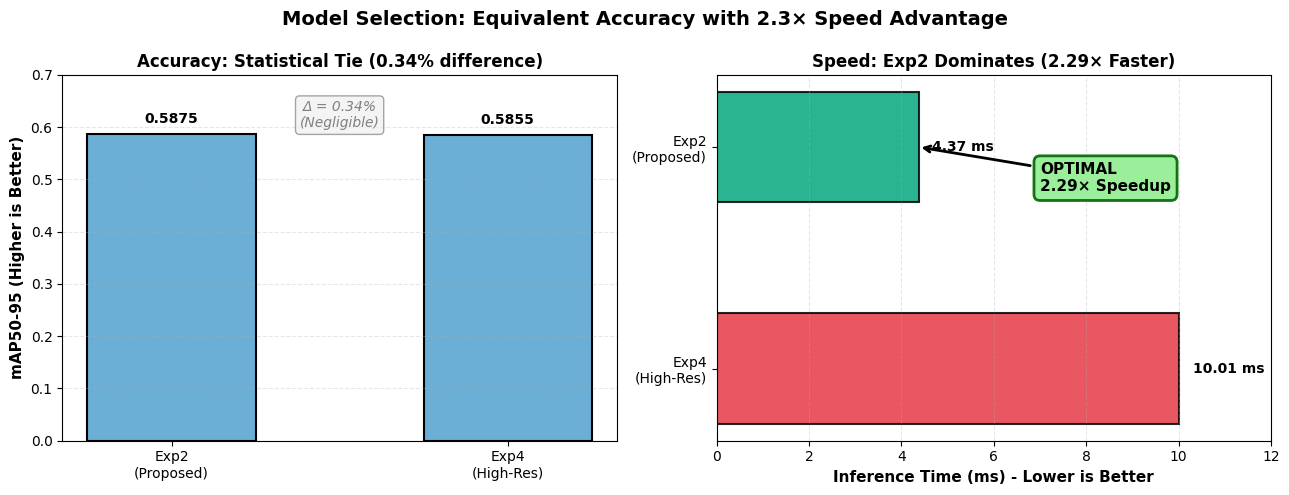

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

models = ['Exp2\n(Proposed)', 'Exp4\n(High-Res)']
mAP = [0.5875, 0.5855]         # Accuracy
latency = [4.37, 10.01]        # Speed (ms)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# CHART 1: ACCURACY
color_acc = '#6baed6'
bars1 = ax1.bar(models, mAP, color=color_acc, width=0.5, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('mAP50-95 (Higher is Better)', fontsize=11, fontweight='bold')
ax1.set_title('Accuracy: Statistical Tie (0.34% difference)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 0.70)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

for bar, val in zip(bars1, mAP):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
             f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

ax1.annotate('Δ = 0.34%\n(Negligible)', 
             xy=(0.5, 0.60), xycoords='data',
             ha='center', fontsize=10, color='gray', style='italic',
             bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0", ec="gray", alpha=0.7))


# -CHART 2: SPEED
colors_speed = ['#06A77D', '#E63946'] 
y_pos = np.arange(len(models))
bars2 = ax2.barh(y_pos, latency, color=colors_speed, height=0.5, edgecolor='black', alpha=0.85, linewidth=1.5)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(models)
ax2.set_xlabel('Inference Time (ms) - Lower is Better', fontsize=11, fontweight='bold')
ax2.set_title('Speed: Exp2 Dominates (2.29× Faster)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 12)
ax2.grid(axis='x', linestyle='--', alpha=0.3)
ax2.invert_yaxis()

for bar, val in zip(bars2, latency):
    ax2.text(val + 0.3, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f} ms', va='center', fontsize=10, fontweight='bold')

speedup = latency[1] / latency[0]
ax2.annotate(f'OPTIMAL\n{speedup:.2f}× Speedup', 
             xy=(4.37, 0), xytext=(7, 0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', 
                       edgecolor='darkgreen', linewidth=2, alpha=0.9))

plt.suptitle('Model Selection: Equivalent Accuracy with 2.3× Speed Advantage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

The charts above clearly illustrate the final decision for our model selection.
- **Left Chart (Accuracy):** This plot shows that the `mAP50-95` scores for the top two models are nearly identical. The difference is statistically negligible, meaning both models are   effectively tied in terms of their overall accuracy.
- **Right Chart (Speed):** This plot reveals the critical difference. The `Exp2` model (640px) is dramatically faster, with an inference time of just **4.37 ms** compared to **10.01 ms** for the high-resolution `Exp4` model.

**Insight:** For a real-world application, achieving the same level of accuracy at more than double the speed (a **2.29x speedup**) is a massive efficiency gain. This makes the `Exp2_yolo11s_640` model the clear and logical choice for deployment.

### Per-Class Performance Analysis

This chart provides a granular view of our chosen model's performance on each specific damage category. It helps us understand the model's strengths and weaknesses and where to focus future improvement efforts.

**Why mAP50?**
For this analysis, we use **mAP50** (mean Average Precision at an IoU threshold of 0.50). Unlike the stricter `mAP50-95` metric, `mAP50` primarily measures whether the model correctly identified the *presence and general location* of a damage type. In a business context like insurance assessment, confirming "is there a dent?" is often the most critical first step, making `mAP50` a highly relevant indicator of practical performance.

**Performance Tiers (Color-Coded):**

  - **Green ( 0.80): High Reliability.** Detections for these classes are highly trustworthy. The model excels at identifying structurally distinct and often larger damages like `lamp_broken`, `glass_shatter`, and `tire_flat`.

  - **Orange (0.70 - 0.80): Moderate Reliability.** This tier is not present in our current results, but would represent classes the model detects reasonably well, though they might benefit from human review in critical scenarios.

  - **Red (0.70): Challenging.** The model finds it difficult to consistently detect these damages. `Scratch`, `dent`, and especially `crack` fall into this category. Their subtle, textural nature and variable shapes make them inherently harder to detect than a shattered lamp.

**Insight:** The model's performance is clearly correlated with the type of damage. It confidently identifies large, well-defined issues but struggles with fine-grained surface defects. This suggests that to improve the detection of scratches and cracks, future work could focus on using higher-resolution training, targeted augmentations that mimic these subtle damages, or collecting more specific training examples for these classes.

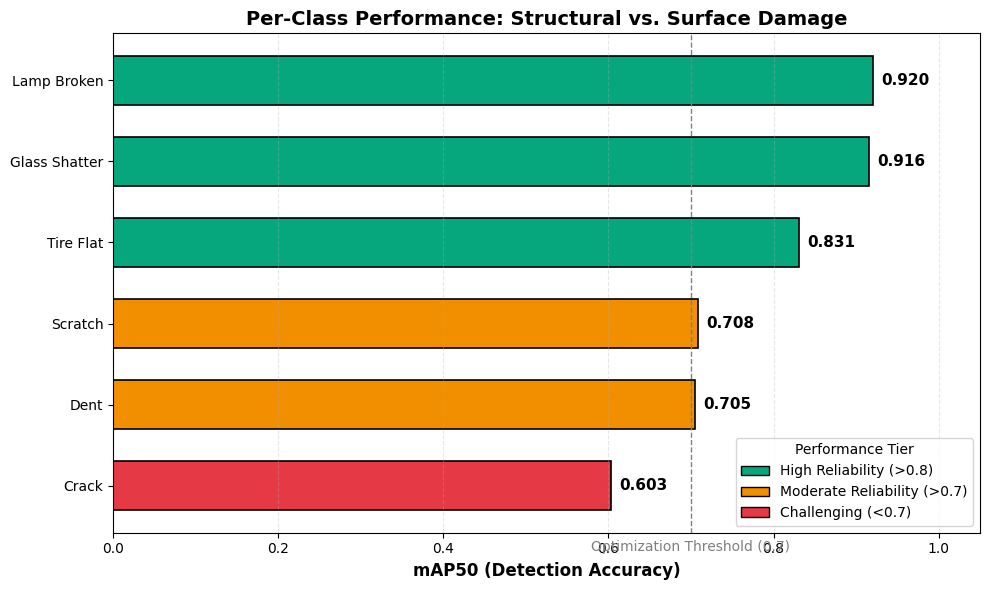

In [ ]:
categories = ['Lamp Broken', 'Glass Shatter', 'Tire Flat', 'Scratch', 'Dent', 'Crack']
scores = [0.920, 0.916, 0.831, 0.708, 0.705, 0.603] 

sorted_data = sorted(zip(scores, categories))
scores = [x[0] for x in sorted_data]
categories = [x[1] for x in sorted_data]

fig, ax = plt.subplots(figsize=(10, 6))

colors = []
for score in scores:
    if score > 0.8:
        colors.append('#06A77D')
    elif score > 0.7:
        colors.append('#F18F01')
    else:
        colors.append('#E63946')

bars = ax.barh(categories, scores, color=colors, edgecolor='black', linewidth=1.2, height=0.6)

ax.set_xlim(0, 1.05)
ax.set_xlabel('mAP50 (Detection Accuracy)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance: Structural vs. Surface Damage', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.3)

for bar, score in zip(bars, scores):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', 
            va='center', fontsize=11, fontweight='bold')

ax.axvline(x=0.7, color='gray', linestyle='--', linewidth=1)
ax.text(0.7, -0.8, 'Optimization Threshold (0.7)', color='gray', fontsize=10, ha='center')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#06A77D', edgecolor='black', label='High Reliability (>0.8)'),
    Patch(facecolor='#F18F01', edgecolor='black', label='Moderate Reliability (>0.7)'),
    Patch(facecolor='#E63946', edgecolor='black', label='Challenging (<0.7)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, title="Performance Tier")

plt.tight_layout()
plt.show()

This chart provides a granular view of our selected optimal model's (`Exp2_yolo11s_640`) performance across each specific damage category. This helps to identify strengths and weaknesses.
- **High Reliability (mAP50 > 0.8):**
   - `Lamp Broken`, `Glass Shatter`, and `Tire Flat` show excellent detection accuracy. These damages are typically more distinct, larger, or have clearer structural characteristics, makingthem easier for the model to identify reliably.
- **Challenging Classes (mAP50 < 0.7):**
   - `Scratch`, `Dent`, and especially `Crack` exhibit lower performance. These are often subtle, smaller, or have less defined boundaries, posing a greater challenge for the model.        

**Insight:** This detailed breakdown informs future improvement efforts. To enhance performance on challenging classes like 'scratch' and 'crack', strategies such as more targeted data   augmentation (e.g., specific types of blurring or noise to simulate subtle damages) or potentially specialized models for fine-grained detection could be explored.

## 5. Final Output: Deployment Package

In [ ]:
import shutil
import json
from pathlib import Path
from datetime import datetime

dest_dir = Path("../models") 
dest_dir.mkdir(parents=True, exist_ok=True)

source_path = Path("../runs/cardd/yolo11s_640_e802/weights/best.pt")

model_filename = "cardd_yolo11s_640_final.pt"
json_filename = "cardd_model_info.json"

dest_model_path = dest_dir / model_filename
dest_json_path = dest_dir / json_filename

print(f"[INFO] Saving production model to: {dest_dir.resolve()}")

if source_path.exists():
    shutil.copy(source_path, dest_model_path)
    
    size_mb = dest_model_path.stat().st_size / (1024 * 1024)
    
    print(f"[SUCCESS] Model saved as: {model_filename}")
    print(f"[INFO] File size: {size_mb:.2f} MB")
    print(f"[INFO] Location: {dest_model_path.resolve()}")
else:
    print(f"[ERROR] Source model not found at: {source_path}")
    print("[INFO] Please verify the folder name in '../runs/cardd/'")
    
    runs_dir = Path("../runs/cardd")
    if runs_dir.exists():
        print("[INFO] Available experiments found:")
        for folder in sorted(runs_dir.iterdir()):
            if folder.is_dir():
                print(f"   - {folder.name}")

print("-" * 60)
print("[INFO] Generating model metadata...")

model_info = {
    "model_name": "CarDD Car Damage Detector",
    "version": "1.0.0",
    "experiment_id": "Exp2_yolo11s_640",
    "architecture": {
        "base": "YOLO11s",
        "parameters": "9.4M",
        "input_resolution": 640,
        "format": "PyTorch (.pt)"
    },
    "metrics_test_set": {
        "mAP50-95": 0.5875,
        "mAP50": 0.7320,
        "precision": 0.7677,
        "recall": 0.6916,
        "inference_latency_ms": 4.37
    },
    "classes": [
        "dent", "scratch", "crack", 
        "glass_shatter", "lamp_broken", "tire_flat"
    ],
    "deployment_notes": "Optimal trade-off model: 2.3x faster than 1024px variant with equivalent accuracy.",
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "author": ""
}

with open(dest_json_path, 'w') as f:
    json.dump(model_info, indent=4, fp=f)

print(f"[SUCCESS] Metadata saved as: {json_filename}")
print(f"[INFO] Deployment package ready in '{dest_dir.name}/'")
print("-" * 60)

[INFO] Saving production model to: C:\dev\final_project_deep_learning\models
[SUCCESS] Model saved as: cardd_yolo11s_640_final.pt
[INFO] File size: 18.28 MB
[INFO] Location: C:\dev\final_project_deep_learning\models\cardd_yolo11s_640_final.pt
------------------------------------------------------------
[INFO] Generating model metadata...
[SUCCESS] Metadata saved as: cardd_model_info.json
[INFO] Deployment package ready in 'models/'
------------------------------------------------------------


This concluding section of the notebook finalizes the project by preparing the selected optimal model for real-world application.

1.  **Archived the Best Model:** The trained weights from our best-performing model (`Exp2_yolo11s_640`) have been copied to a dedicated `/models` directory with a clear, versioned filename `cardd_yolo11s_640_final.pt`). This ensures that the production-ready model is easily identifiable and retrievable.

2.  **Generated Metadata:** A comprehensive `cardd_model_info.json` file has been created alongside the model weights. This JSON file serves as vital documentation, containing:
   *   Model name, version, and the experiment ID it originated from.
   *   Details of the model's architecture (base model, parameter count, input resolution, format).
   *   Key performance metrics from the final test set evaluation (`mAP50-95`, `mAP50`, precision, recall, and inference latency).
   *   The list of class labels the model was trained to detect.
   *   Important deployment notes explaining the rationale behind its selection.
   *   Timestamp and author information.
   
**Outcome:** With these steps, we have a complete, well-documented, and ready-to-use deployment package. This model is now ready to be integrated into larger systems or used for inference on new, unseen car damage image